In [ ]:
"""
Temporal Convolutional Network
------------------------------
"""

import math
from typing import Optional, Sequence, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F

from darts.logging import get_logger, raise_if_not
from darts.models.forecasting.pl_forecasting_module import (
    PLPastCovariatesModule,
    io_processor,
)
from darts.models.forecasting.torch_forecasting_model import PastCovariatesTorchModel
from darts.timeseries import TimeSeries
from darts.utils.data import PastCovariatesShiftedDataset
from darts.utils.torch import MonteCarloDropout

logger = get_logger(__name__)


class _ResidualBlock(nn.Module):
    def __init__(
        self,
        num_filters: int,
        kernel_size: int,
        dilation_base: int,
        dropout: float,
        weight_norm: bool,
        nr_blocks_below: int,
        num_layers: int,
        input_size: int,
        target_size: int,
    ):
        """PyTorch module implementing a residual block module used in `_TCNModule`.

        Parameters
        ----------
        num_filters
            The number of filters in a convolutional layer of the TCN.
        kernel_size
            The size of every kernel in a convolutional layer.
        dilation_base
            The base of the exponent that will determine the dilation on every level.
        dropout
            The dropout to be applied to every convolutional layer.
        weight_norm
            Boolean value indicating whether to use weight normalization.
        nr_blocks_below
            The number of residual blocks before the current one.
        num_layers
            The number of convolutional layers.
        input_size
            The dimensionality of the input time series of the whole network.
        target_size
            The dimensionality of the output time series of the whole network.

        Inputs
        ------
        x of shape `(batch_size, in_dimension, input_chunk_length)`
            Tensor containing the features of the input sequence.
            in_dimension is equal to `input_size` if this is the first residual block,
            in all other cases it is equal to `num_filters`.

        Outputs
        -------
        y of shape `(batch_size, out_dimension, input_chunk_length)`
            Tensor containing the output sequence of the residual block.
            out_dimension is equal to `output_size` if this is the last residual block,
            in all other cases it is equal to `num_filters`.
        """
        super().__init__()

        self.dilation_base = dilation_base
        self.kernel_size = kernel_size
        self.dropout1 = MonteCarloDropout(dropout)
        self.dropout2 = MonteCarloDropout(dropout)
        self.num_layers = num_layers
        self.nr_blocks_below = nr_blocks_below

        input_dim = input_size if nr_blocks_below == 0 else num_filters
        output_dim = target_size if nr_blocks_below == num_layers - 1 else num_filters
        self.conv1 = nn.Conv1d(
            input_dim,
            num_filters,
            kernel_size,
            dilation=(dilation_base**nr_blocks_below),
        )
        self.conv2 = nn.Conv1d(
            num_filters,
            output_dim,
            kernel_size,
            dilation=(dilation_base**nr_blocks_below),
        )
        if weight_norm:
            self.conv1, self.conv2 = (
                nn.utils.weight_norm(self.conv1),
                nn.utils.weight_norm(self.conv2),
            )

        if input_dim != output_dim:
            self.conv3 = nn.Conv1d(input_dim, output_dim, 1)

    def forward(self, x):
        residual = x

        # first step
        left_padding = (self.dilation_base**self.nr_blocks_below) * (
            self.kernel_size - 1
        )
        x = F.pad(x, (left_padding, 0))
        x = self.dropout1(F.relu(self.conv1(x)))

        # second step
        x = F.pad(x, (left_padding, 0))
        x = self.conv2(x)
        if self.nr_blocks_below < self.num_layers - 1:
            x = F.relu(x)
        x = self.dropout2(x)

        # add residual
        if self.conv1.in_channels != self.conv2.out_channels:
            residual = self.conv3(residual)
        x = x + residual

        return x


class _TCNModule(PLPastCovariatesModule):
    def __init__(
        self,
        input_size: int,
        kernel_size: int,
        num_filters: int,
        num_layers: Optional[int],
        dilation_base: int,
        weight_norm: bool,
        target_size: int,
        nr_params: int,
        target_length: int,
        dropout: float,
        **kwargs,
    ):
        """PyTorch module implementing a dilated TCN module used in `TCNModel`.


        Parameters
        ----------
        input_size
            The dimensionality of the input time series.
        target_size
            The dimensionality of the output time series.
        nr_params
            The number of parameters of the likelihood (or 1 if no likelihood is used).
        target_length
            Number of time steps the torch module will predict into the future at once.
        kernel_size
            The size of every kernel in a convolutional layer.
        num_filters
            The number of filters in a convolutional layer of the TCN.
        num_layers
            The number of convolutional layers.
        weight_norm
            Boolean value indicating whether to use weight normalization.
        dilation_base
            The base of the exponent that will determine the dilation on every level.
        dropout
            The dropout rate for every convolutional layer.
        **kwargs
            all parameters required for :class:`darts.models.forecasting.pl_forecasting_module.PLForecastingModule`
            base class.

        Inputs
        ------
        x of shape `(batch_size, input_chunk_length, input_size)`
            Tensor containing the features of the input sequence.

        Outputs
        -------
        y of shape `(batch_size, input_chunk_length, target_size, nr_params)`
            Tensor containing the predictions of the next 'output_chunk_length' points in the last
            'output_chunk_length' entries of the tensor. The entries before contain the data points
            leading up to the first prediction, all in chronological order.
        """

        super().__init__(**kwargs)

        # Defining parameters
        self.input_size = input_size
        self.n_filters = num_filters
        self.kernel_size = kernel_size
        self.target_length = target_length
        self.target_size = target_size
        self.nr_params = nr_params
        self.dilation_base = dilation_base

        # If num_layers is not passed, compute number of layers needed for full history coverage
        if num_layers is None and dilation_base > 1:
            num_layers = math.ceil(
                math.log(
                    (self.input_chunk_length - 1)
                    * (dilation_base - 1)
                    / (kernel_size - 1)
                    / 2
                    + 1,
                    dilation_base,
                )
            )
            logger.info("Number of layers chosen: " + str(num_layers))
        elif num_layers is None:
            num_layers = math.ceil(
                (self.input_chunk_length - 1) / (kernel_size - 1) / 2
            )
            logger.info("Number of layers chosen: " + str(num_layers))
        self.num_layers = num_layers

        # Building TCN module
        self.res_blocks_list = []
        for i in range(num_layers):
            res_block = _ResidualBlock(
                num_filters=num_filters,
                kernel_size=kernel_size,
                dilation_base=dilation_base,
                dropout=dropout,
                weight_norm=weight_norm,
                nr_blocks_below=i,
                num_layers=num_layers,
                input_size=self.input_size,
                target_size=target_size * nr_params,
            )
            self.res_blocks_list.append(res_block)
        self.res_blocks = nn.ModuleList(self.res_blocks_list)

    @io_processor
    def forward(self, x_in: Tuple):
        x, _ = x_in
        # data is of size (batch_size, input_chunk_length, input_size)
        batch_size = x.size(0)
        x = x.transpose(1, 2)

        for res_block in self.res_blocks_list:
            x = res_block(x)

        x = x.transpose(1, 2)
        x = x.view(
            batch_size, self.input_chunk_length, self.target_size, self.nr_params
        )

        return x

    @property
    def first_prediction_index(self) -> int:
        return -self.output_chunk_length


class TCNModel(PastCovariatesTorchModel):
    def __init__(
        self,
        input_chunk_length: int,
        output_chunk_length: int,
        output_chunk_shift: int = 0,
        kernel_size: int = 3,
        num_filters: int = 3,
        num_layers: Optional[int] = None,
        dilation_base: int = 2,
        weight_norm: bool = False,
        dropout: float = 0.2,
        **kwargs,
    ):
        """Temporal Convolutional Network Model (TCN).

        This is an implementation of a dilated TCN used for forecasting, inspired from [1]_.

        This model supports past covariates (known for `input_chunk_length` points before prediction time).

        Parameters
        ----------
        input_chunk_length
            Number of time steps in the past to take as a model input (per chunk). Applies to the target
            series, and past and/or future covariates (if the model supports it).
        output_chunk_length
            Number of time steps predicted at once (per chunk) by the internal model. Also, the number of future values
            from future covariates to use as a model input (if the model supports future covariates). It is not the same
            as forecast horizon `n` used in `predict()`, which is the desired number of prediction points generated
            using either a one-shot- or autoregressive forecast. Setting `n <= output_chunk_length` prevents
            auto-regression. This is useful when the covariates don't extend far enough into the future, or to prohibit
            the model from using future values of past and / or future covariates for prediction (depending on the
            model's covariate support).
        output_chunk_shift
            Optionally, the number of steps to shift the start of the output chunk into the future (relative to the
            input chunk end). This will create a gap between the input and output. If the model supports
            `future_covariates`, the future values are extracted from the shifted output chunk. Predictions will start
            `output_chunk_shift` steps after the end of the target `series`. If `output_chunk_shift` is set, the model
            cannot generate autoregressive predictions (`n > output_chunk_length`).
        kernel_size
            The size of every kernel in a convolutional layer.
        num_filters
            The number of filters in a convolutional layer of the TCN.
        weight_norm
            Boolean value indicating whether to use weight normalization.
        dilation_base
            The base of the exponent that will determine the dilation on every level.
        num_layers
            The number of convolutional layers.
        dropout
            The dropout rate for every convolutional layer. This is compatible with Monte Carlo dropout
            at inference time for model uncertainty estimation (enabled with ``mc_dropout=True`` at
            prediction time).
        **kwargs
            Optional arguments to initialize the pytorch_lightning.Module, pytorch_lightning.Trainer, and
            Darts' :class:`TorchForecastingModel`.

        loss_fn
            PyTorch loss function used for training.
            This parameter will be ignored for probabilistic models if the ``likelihood`` parameter is specified.
            Default: ``torch.nn.MSELoss()``.
        likelihood
            One of Darts' :meth:`Likelihood <darts.utils.likelihood_models.Likelihood>` models to be used for
            probabilistic forecasts. Default: ``None``.
        torch_metrics
            A torch metric or a ``MetricCollection`` used for evaluation. A full list of available metrics can be found
            at https://torchmetrics.readthedocs.io/en/latest/. Default: ``None``.
        optimizer_cls
            The PyTorch optimizer class to be used. Default: ``torch.optim.Adam``.
        optimizer_kwargs
            Optionally, some keyword arguments for the PyTorch optimizer (e.g., ``{'lr': 1e-3}``
            for specifying a learning rate). Otherwise the default values of the selected ``optimizer_cls``
            will be used. Default: ``None``.
        lr_scheduler_cls
            Optionally, the PyTorch learning rate scheduler class to be used. Specifying ``None`` corresponds
            to using a constant learning rate. Default: ``None``.
        lr_scheduler_kwargs
            Optionally, some keyword arguments for the PyTorch learning rate scheduler. Default: ``None``.
        use_reversible_instance_norm
            Whether to use reversible instance normalization `RINorm` against distribution shift as shown in [2]_.
            It is only applied to the features of the target series and not the covariates.
        batch_size
            Number of time series (input and output sequences) used in each training pass. Default: ``32``.
        n_epochs
            Number of epochs over which to train the model. Default: ``100``.
        model_name
            Name of the model. Used for creating checkpoints and saving tensorboard data. If not specified,
            defaults to the following string ``"YYYY-mm-dd_HH_MM_SS_torch_model_run_PID"``, where the initial part
            of the name is formatted with the local date and time, while PID is the processed ID (preventing models
            spawned at the same time by different processes to share the same model_name). E.g.,
            ``"2021-06-14_09_53_32_torch_model_run_44607"``.
        work_dir
            Path of the working directory, where to save checkpoints and Tensorboard summaries.
            Default: current working directory.
        log_tensorboard
            If set, use Tensorboard to log the different parameters. The logs will be located in:
            ``"{work_dir}/darts_logs/{model_name}/logs/"``. Default: ``False``.
        nr_epochs_val_period
            Number of epochs to wait before evaluating the validation loss (if a validation
            ``TimeSeries`` is passed to the :func:`fit()` method). Default: ``1``.
        force_reset
            If set to ``True``, any previously-existing model with the same name will be reset (all checkpoints will
            be discarded). Default: ``False``.
        save_checkpoints
            Whether to automatically save the untrained model and checkpoints from training.
            To load the model from checkpoint, call :func:`MyModelClass.load_from_checkpoint()`, where
            :class:`MyModelClass` is the :class:`TorchForecastingModel` class that was used (such as :class:`TFTModel`,
            :class:`NBEATSModel`, etc.). If set to ``False``, the model can still be manually saved using
            :func:`save()` and loaded using :func:`load()`. Default: ``False``.
        add_encoders
            A large number of past and future covariates can be automatically generated with `add_encoders`.
            This can be done by adding multiple pre-defined index encoders and/or custom user-made functions that
            will be used as index encoders. Additionally, a transformer such as Darts' :class:`Scaler` can be added to
            transform the generated covariates. This happens all under one hood and only needs to be specified at
            model creation.
            Read :meth:`SequentialEncoder <darts.dataprocessing.encoders.SequentialEncoder>` to find out more about
            ``add_encoders``. Default: ``None``. An example showing some of ``add_encoders`` features:

            .. highlight:: python
            .. code-block:: python

                def encode_year(idx):
                    return (idx.year - 1950) / 50

                add_encoders={
                    'cyclic': {'future': ['month']},
                    'datetime_attribute': {'future': ['hour', 'dayofweek']},
                    'position': {'past': ['relative'], 'future': ['relative']},
                    'custom': {'past': [encode_year]},
                    'transformer': Scaler(),
                    'tz': 'CET'
                }
            ..
        random_state
            Control the randomness of the weights initialization. Check this
            `link <https://scikit-learn.org/stable/glossary.html#term-random_state>`_ for more details.
            Default: ``None``.
        pl_trainer_kwargs
            By default :class:`TorchForecastingModel` creates a PyTorch Lightning Trainer with several useful presets
            that performs the training, validation and prediction processes. These presets include automatic
            checkpointing, tensorboard logging, setting the torch device and more.
            With ``pl_trainer_kwargs`` you can add additional kwargs to instantiate the PyTorch Lightning trainer
            object. Check the `PL Trainer documentation
            <https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html>`_ for more information about the
            supported kwargs. Default: ``None``.
            Running on GPU(s) is also possible using ``pl_trainer_kwargs`` by specifying keys ``"accelerator",
            "devices", and "auto_select_gpus"``. Some examples for setting the devices inside the ``pl_trainer_kwargs``
            dict:rgs``
            dict:

            - ``{"accelerator": "cpu"}`` for CPU,
            - ``{"accelerator": "gpu", "devices": [i]}`` to use only GPU ``i`` (``i`` must be an integer),
            - ``{"accelerator": "gpu", "devices": -1, "auto_select_gpus": True}`` to use all available GPUS.

            For more info, see here:
            https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html#trainer-flags , and
            https://pytorch-lightning.readthedocs.io/en/stable/accelerators/gpu_basic.html#train-on-multiple-gpus

            With parameter ``"callbacks"`` you can add custom or PyTorch-Lightning built-in callbacks to Darts'
            :class:`TorchForecastingModel`. Below is an example for adding EarlyStopping to the training process.
            The model will stop training early if the validation loss `val_loss` does not improve beyond
            specifications. For more information on callbacks, visit:
            `PyTorch Lightning Callbacks
            <https://pytorch-lightning.readthedocs.io/en/stable/extensions/callbacks.html>`_

            .. highlight:: python
            .. code-block:: python

                from pytorch_lightning.callbacks.early_stopping import EarlyStopping

                # stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
                # a period of 5 epochs (`patience`)
                my_stopper = EarlyStopping(
                    monitor="val_loss",
                    patience=5,
                    min_delta=0.05,
                    mode='min',
                )

                pl_trainer_kwargs={"callbacks": [my_stopper]}
            ..

            Note that you can also use a custom PyTorch Lightning Trainer for training and prediction with optional
            parameter ``trainer`` in :func:`fit()` and :func:`predict()`.
        show_warnings
            whether to show warnings raised from PyTorch Lightning. Useful to detect potential issues of
            your forecasting use case. Default: ``False``.

        References
        ----------
        .. [1] https://arxiv.org/abs/1803.01271
        .. [2] T. Kim et al. "Reversible Instance Normalization for Accurate Time-Series Forecasting against
                Distribution Shift", https://openreview.net/forum?id=cGDAkQo1C0p

        Examples
        --------
        >>> from darts.datasets import WeatherDataset
        >>> from darts.models import TCNModel
        >>> series = WeatherDataset().load()
        >>> # predicting atmospheric pressure
        >>> target = series['p (mbar)'][:100]
        >>> # optionally, use past observed rainfall (pretending to be unknown beyond index 100)
        >>> past_cov = series['rain (mm)'][:100]
        >>> # `output_chunk_length` must be strictly smaller than `input_chunk_length`
        >>> model = TCNModel(
        >>>     input_chunk_length=12,
        >>>     output_chunk_length=6,
        >>>     n_epochs=20,
        >>> )
        >>> model.fit(target, past_covariates=past_cov)
        >>> pred = model.predict(6)
        >>> pred.values()
        array([[-80.48476824],
               [-80.47896667],
               [-41.77135603],
               [-41.76158729],
               [-41.76854107],
               [-41.78166819]])

        .. note::
            `DeepTCN example notebook <https://unit8co.github.io/darts/examples/09-DeepTCN-examples.html>`_ presents
            techniques that can be used to improve the forecasts quality compared to this simple usage example.
        """

        raise_if_not(
            kernel_size < input_chunk_length,
            "The kernel size must be strictly smaller than the input length.",
            logger,
        )
        raise_if_not(
            output_chunk_length < input_chunk_length,
            "The output length must be strictly smaller than the input length",
            logger,
        )

        super().__init__(**self._extract_torch_model_params(**self.model_params))

        # extract pytorch lightning module kwargs
        self.pl_module_params = self._extract_pl_module_params(**self.model_params)

        self.kernel_size = kernel_size
        self.num_filters = num_filters
        self.num_layers = num_layers
        self.dilation_base = dilation_base
        self.dropout = dropout
        self.weight_norm = weight_norm

    @property
    def supports_multivariate(self) -> bool:
        return True

    def _create_model(self, train_sample: Tuple[torch.Tensor]) -> torch.nn.Module:
        # samples are made of (past_target, past_covariates, future_target)
        input_dim = train_sample[0].shape[1] + (
            train_sample[1].shape[1] if train_sample[1] is not None else 0
        )
        output_dim = train_sample[-1].shape[1]
        nr_params = 1 if self.likelihood is None else self.likelihood.num_parameters

        return _TCNModule(
            input_size=input_dim,
            target_size=output_dim,
            nr_params=nr_params,
            kernel_size=self.kernel_size,
            num_filters=self.num_filters,
            num_layers=self.num_layers,
            dilation_base=self.dilation_base,
            target_length=self.output_chunk_length,
            dropout=self.dropout,
            weight_norm=self.weight_norm,
            **self.pl_module_params,
        )

    def _build_train_dataset(
        self,
        target: Sequence[TimeSeries],
        past_covariates: Optional[Sequence[TimeSeries]],
        future_covariates: Optional[Sequence[TimeSeries]],
        sample_weight: Optional[Sequence[TimeSeries]],
        max_samples_per_ts: Optional[int],
    ) -> PastCovariatesShiftedDataset:
        return PastCovariatesShiftedDataset(
            target_series=target,
            covariates=past_covariates,
            length=self.input_chunk_length,
            shift=self.output_chunk_length + self.output_chunk_shift,
            max_samples_per_ts=max_samples_per_ts,
            use_static_covariates=self.uses_static_covariates,
            sample_weight=sample_weight,
        )

ModuleNotFoundError: No module named 'darts'

In [ ]:
"""
Temporal Convolutional Network
------------------------------
"""

import math
from typing import Optional, Sequence, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F

from darts.logging import get_logger, raise_if_not
from darts.models.forecasting.pl_forecasting_module import (
    PLPastCovariatesModule,
    io_processor,
)
from darts.models.forecasting.torch_forecasting_model import PastCovariatesTorchModel
from darts.timeseries import TimeSeries
from darts.utils.data import PastCovariatesShiftedDataset
from darts.utils.torch import MonteCarloDropout

logger = get_logger(__name__)


class _ResidualBlock(nn.Module):
    def __init__(
        self,
        num_filters: int,
        kernel_size: int,
        dilation_base: int,
        dropout: float,
        weight_norm: bool,
        nr_blocks_below: int,
        num_layers: int,
        input_size: int,
        target_size: int,
    ):

        super().__init__()

        self.dilation_base = dilation_base
        self.kernel_size = kernel_size
        self.dropout1 = MonteCarloDropout(dropout)
        self.dropout2 = MonteCarloDropout(dropout)
        self.num_layers = num_layers
        self.nr_blocks_below = nr_blocks_below

        input_dim = input_size if nr_blocks_below == 0 else num_filters
        output_dim = target_size if nr_blocks_below == num_layers - 1 else num_filters
        self.conv1 = nn.Conv1d(
            input_dim,
            num_filters,
            kernel_size,
            dilation=(dilation_base**nr_blocks_below),
        )
        self.conv2 = nn.Conv1d(
            num_filters,
            output_dim,
            kernel_size,
            dilation=(dilation_base**nr_blocks_below),
        )
        if weight_norm:
            self.conv1, self.conv2 = (
                nn.utils.weight_norm(self.conv1),
                nn.utils.weight_norm(self.conv2),
            )

        if input_dim != output_dim:
            self.conv3 = nn.Conv1d(input_dim, output_dim, 1)

    def forward(self, x):
        residual = x

        # first step
        left_padding = (self.dilation_base**self.nr_blocks_below) * (
            self.kernel_size - 1
        )
        x = F.pad(x, (left_padding, 0))
        x = self.dropout1(F.relu(self.conv1(x)))

        # second step
        x = F.pad(x, (left_padding, 0))
        x = self.conv2(x)
        if self.nr_blocks_below < self.num_layers - 1:
            x = F.relu(x)
        x = self.dropout2(x)

        # add residual
        if self.conv1.in_channels != self.conv2.out_channels:
            residual = self.conv3(residual)
        x = x + residual

        return x


class _TCNModule(PLPastCovariatesModule):
    def __init__(
        self,
        input_size: int,
        kernel_size: int,
        num_filters: int,
        num_layers: Optional[int],
        dilation_base: int,
        weight_norm: bool,
        target_size: int,
        nr_params: int,
        target_length: int,
        dropout: float,
        **kwargs,
    ):


        super().__init__(**kwargs)

        # Defining parameters
        self.input_size = input_size
        self.n_filters = num_filters
        self.kernel_size = kernel_size
        self.target_length = target_length
        self.target_size = target_size
        self.nr_params = nr_params
        self.dilation_base = dilation_base

        # If num_layers is not passed, compute number of layers needed for full history coverage
        if num_layers is None and dilation_base > 1:
            num_layers = math.ceil(
                math.log(
                    (self.input_chunk_length - 1)
                    * (dilation_base - 1)
                    / (kernel_size - 1)
                    / 2
                    + 1,
                    dilation_base,
                )
            )
            logger.info("Number of layers chosen: " + str(num_layers))
        elif num_layers is None:
            num_layers = math.ceil(
                (self.input_chunk_length - 1) / (kernel_size - 1) / 2
            )
            logger.info("Number of layers chosen: " + str(num_layers))
        self.num_layers = num_layers

        # Building TCN module
        self.res_blocks_list = []
        for i in range(num_layers):
            res_block = _ResidualBlock(
                num_filters=num_filters,
                kernel_size=kernel_size,
                dilation_base=dilation_base,
                dropout=dropout,
                weight_norm=weight_norm,
                nr_blocks_below=i,
                num_layers=num_layers,
                input_size=self.input_size,
                target_size=target_size * nr_params,
            )
            self.res_blocks_list.append(res_block)
        self.res_blocks = nn.ModuleList(self.res_blocks_list)

    @io_processor
    def forward(self, x_in: Tuple):
        x, _ = x_in
        # data is of size (batch_size, input_chunk_length, input_size)
        batch_size = x.size(0)
        x = x.transpose(1, 2)

        for res_block in self.res_blocks_list:
            x = res_block(x)

        x = x.transpose(1, 2)
        x = x.view(
            batch_size, self.input_chunk_length, self.target_size, self.nr_params
        )

        return x

    @property
    def first_prediction_index(self) -> int:
        return -self.output_chunk_length


class TCNModel(PastCovariatesTorchModel):
    def __init__(
        self,
        input_chunk_length: int,
        output_chunk_length: int,
        output_chunk_shift: int = 0,
        kernel_size: int = 3,
        num_filters: int = 3,
        num_layers: Optional[int] = None,
        dilation_base: int = 2,
        weight_norm: bool = False,
        dropout: float = 0.2,
        **kwargs,
    ):


        raise_if_not(
            kernel_size < input_chunk_length,
            "The kernel size must be strictly smaller than the input length.",
            logger,
        )
        raise_if_not(
            output_chunk_length < input_chunk_length,
            "The output length must be strictly smaller than the input length",
            logger,
        )

        super().__init__(**self._extract_torch_model_params(**self.model_params))

        # extract pytorch lightning module kwargs
        self.pl_module_params = self._extract_pl_module_params(**self.model_params)

        self.kernel_size = kernel_size
        self.num_filters = num_filters
        self.num_layers = num_layers
        self.dilation_base = dilation_base
        self.dropout = dropout
        self.weight_norm = weight_norm

    @property
    def supports_multivariate(self) -> bool:
        return True

    def _create_model(self, train_sample: Tuple[torch.Tensor]) -> torch.nn.Module:
        # samples are made of (past_target, past_covariates, future_target)
        input_dim = train_sample[0].shape[1] + (
            train_sample[1].shape[1] if train_sample[1] is not None else 0
        )
        output_dim = train_sample[-1].shape[1]
        nr_params = 1 if self.likelihood is None else self.likelihood.num_parameters

        return _TCNModule(
            input_size=input_dim,
            target_size=output_dim,
            nr_params=nr_params,
            kernel_size=self.kernel_size,
            num_filters=self.num_filters,
            num_layers=self.num_layers,
            dilation_base=self.dilation_base,
            target_length=self.output_chunk_length,
            dropout=self.dropout,
            weight_norm=self.weight_norm,
            **self.pl_module_params,
        )

    def _build_train_dataset(
        self,
        target: Sequence[TimeSeries],
        past_covariates: Optional[Sequence[TimeSeries]],
        future_covariates: Optional[Sequence[TimeSeries]],
        sample_weight: Optional[Sequence[TimeSeries]],
        max_samples_per_ts: Optional[int],
    ) -> PastCovariatesShiftedDataset:
        return PastCovariatesShiftedDataset(
            target_series=target,
            covariates=past_covariates,
            length=self.input_chunk_length,
            shift=self.output_chunk_length + self.output_chunk_shift,
            max_samples_per_ts=max_samples_per_ts,
            use_static_covariates=self.uses_static_covariates,
            sample_weight=sample_weight,
        )

In [ ]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.2/934.2 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.7/314.7 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.4/271.4 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.5/890.5 kB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.7 MB/s eta 0:00:0

In [ ]:

import math
from typing import Optional, Sequence, Tuple
import yfinance as yf
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd  # Import pandas

from darts.logging import get_logger, raise_if_not
from darts.models.forecasting.pl_forecasting_module import (
    PLPastCovariatesModule,
    io_processor,
)
from darts.models.forecasting.torch_forecasting_model import PastCovariatesTorchModel
from darts.timeseries import TimeSeries
from darts.utils.data import PastCovariatesShiftedDataset
from darts.utils.torch import MonteCarloDropout

logger = get_logger(__name__)

# Função para baixar os dados de ações da AVIR
def get_stock_data(stock: str, start_date: str, end_date: str) -> TimeSeries:
    stock_data = yf.download(stock, start=start_date, end=end_date)
    # Ensure the 'Date' column is the index and is of datetime type
    stock_data = stock_data.reset_index()
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])
    stock_data = stock_data.set_index('Date')
    # Resample the data to daily frequency and fill missing values with forward fill
    stock_data = stock_data.resample('D').ffill()
    series = TimeSeries.from_dataframe(stock_data, value_cols='Close', freq='D') # Specify the frequency
    return series

# Baixar os dados da ação AVIR de um período específico
stock_series = get_stock_data('AVIR', '2020-01-01', '2023-01-01')


# Definição das classes de modelo TCN e módulos
class _ResidualBlock(nn.Module):
    def __init__(
        self,
        num_filters: int,
        kernel_size: int,
        dilation_base: int,
        dropout: float,
        weight_norm: bool,
        nr_blocks_below: int,
        num_layers: int,
        input_size: int,
        target_size: int,
    ):
        super().__init__()

        self.dilation_base = dilation_base
        self.kernel_size = kernel_size
        self.dropout1 = MonteCarloDropout(dropout)
        self.dropout2 = MonteCarloDropout(dropout)
        self.num_layers = num_layers
        self.nr_blocks_below = nr_blocks_below

        input_dim = input_size if nr_blocks_below == 0 else num_filters
        output_dim = target_size if nr_blocks_below == num_layers - 1 else num_filters
        self.conv1 = nn.Conv1d(
            input_dim,
            num_filters,
            kernel_size,
            dilation=(dilation_base**nr_blocks_below),
        )
        self.conv2 = nn.Conv1d(
            num_filters,
            output_dim,
            kernel_size,
            dilation=(dilation_base**nr_blocks_below),
        )
        if weight_norm:
            self.conv1, self.conv2 = (
                nn.utils.weight_norm(self.conv1),
                nn.utils.weight_norm(self.conv2),
            )

        if input_dim != output_dim:
            self.conv3 = nn.Conv1d(input_dim, output_dim, 1)

    def forward(self, x):
        residual = x

        left_padding = (self.dilation_base**self.nr_blocks_below) * (
            self.kernel_size - 1
        )
        x = F.pad(x, (left_padding, 0))
        x = self.dropout1(F.relu(self.conv1(x)))

        x = F.pad(x, (left_padding, 0))
        x = self.conv2(x)
        if self.nr_blocks_below < self.num_layers - 1:
            x = F.relu(x)
        x = self.dropout2(x)

        if self.conv1.in_channels != self.conv2.out_channels:
            residual = self.conv3(residual)
        x = x + residual

        return x


class _TCNModule(PLPastCovariatesModule):
    def __init__(
        self,
        input_size: int,
        kernel_size: int,
        num_filters: int,
        num_layers: Optional[int],
        dilation_base: int,
        weight_norm: bool,
        target_size: int,
        nr_params: int,
        target_length: int,
        dropout: float,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.input_size = input_size
        self.n_filters = num_filters
        self.kernel_size = kernel_size
        self.target_length = target_length
        self.target_size = target_size
        self.nr_params = nr_params
        self.dilation_base = dilation_base

        if num_layers is None and dilation_base > 1:
            num_layers = math.ceil(
                math.log(
                    (self.input_chunk_length - 1)
                    * (dilation_base - 1)
                    / (kernel_size - 1)
                    / 2
                    + 1,
                    dilation_base,
                )
            )
            logger.info("Number of layers chosen: " + str(num_layers))
        elif num_layers is None:
            num_layers = math.ceil(
                (self.input_chunk_length - 1) / (kernel_size - 1) / 2
            )
            logger.info("Number of layers chosen: " + str(num_layers))
        self.num_layers = num_layers

        self.res_blocks_list = [
            _ResidualBlock(
                num_filters=num_filters,
                kernel_size=kernel_size,
                dilation_base=dilation_base,
                dropout=dropout,
                weight_norm=weight_norm,
                nr_blocks_below=i,
                num_layers=num_layers,
                input_size=self.input_size,
                target_size=target_size * nr_params,
            )
            for i in range(num_layers)
        ]
        self.res_blocks = nn.ModuleList(self.res_blocks_list)

    @io_processor
    def forward(self, x_in: Tuple):
        x, _ = x_in
        batch_size = x.size(0)
        x = x.transpose(1, 2)

        for res_block in self.res_blocks_list:
            x = res_block(x)

        x = x.transpose(1, 2)
        x = x.view(
            batch_size, self.input_chunk_length, self.target_size, self.nr_params
        )

        return x

    @property
    def first_prediction_index(self) -> int:
        return -self.output_chunk_length


class TCNModel(PastCovariatesTorchModel):
    def __init__(
        self,
        input_chunk_length: int,
        output_chunk_length: int,
        output_chunk_shift: int = 0,
        kernel_size: int = 3,
        num_filters: int = 3,
        num_layers: Optional[int] = None,
        dilation_base: int = 2,
        weight_norm: bool = False,
        dropout: float = 0.2,
        **kwargs,
    ):
        raise_if_not(
            kernel_size < input_chunk_length,
            "The kernel size must be strictly smaller than the input length.",
            logger,
        )
        raise_if_not(
            output_chunk_length < input_chunk_length,
            "The output length must be strictly smaller than the input length",
            logger,
        )
        super().__init__(**self._extract_torch_model_params(**self.model_params))

        self.pl_module_params = self._extract_pl_module_params(**self.model_params)
        self.kernel_size = kernel_size
        self.num_filters = num_filters
        self.num_layers = num_layers
        self.dilation_base = dilation_base
        self.dropout = dropout
        self.weight_norm = weight_norm

    @property
    def supports_multivariate(self) -> bool:
        return True

    def _create_model(self, train_sample: Tuple[torch.Tensor]) -> torch.nn.Module:
        input_dim = train_sample[0].shape[1] + (
            train_sample[1].shape[1] if train_sample[1] is not None else 0
        )
        output_dim = train_sample[-1].shape[1]
        nr_params = 1 if self.likelihood is None else self.likelihood.num_parameters

        return _TCNModule(
            input_size=input_dim,
            target_size=output_dim,
            nr_params=nr_params,
            kernel_size=self.kernel_size,
            num_filters=self.num_filters,
            num_layers=self.num_layers,
            dilation_base=self.dilation_base,
            target_length=self.output_chunk_length,
            dropout=self.dropout,
            weight_norm=self.weight_norm,
            **self.pl_module_params,
        )

    def _build_train_dataset(
        self,
        target: Sequence[TimeSeries],
        past_covariates: Optional[Sequence[TimeSeries]],
        future_covariates: Optional[Sequence[TimeSeries]],
        sample_weight: Optional[Sequence[TimeSeries]],
        max_samples_per_ts: Optional[int],
    ) -> PastCovariatesShiftedDataset:
        return PastCovariatesShiftedDataset(
            target_series=target,
            covariates=past_covariates,
            length=self.input_chunk_length,
            shift=self.output_chunk_length + self.output_chunk_shift,
            max_samples_per_ts=max_samples_per_ts,
            use_static_covariates=self.uses_static_covariates,
            sample_weight=sample_weight,
        )

# Ajuste conforme necessário para treino, validação e previsão


[*********************100%***********************]  1 of 1 completed


In [ ]:
import yfinance as yf
import torch
from darts import TimeSeries
from darts.models import TCNModel
import matplotlib.pyplot as plt

# Baixar os dados da ação AVIR usando yfinance
data = yf.download("AVIR", start="2020-01-01", end="2024-01-01")
# Selecionar a coluna 'Close' para análise
series = TimeSeries.from_dataframe(data, value_cols="Close")

# Dividir os dados em treinamento e teste (80% para treinamento, 20% para teste)
train, val = series.split_before(0.8)

# Definir e treinar o modelo TCN
model = TCNModel(
    input_chunk_length=30,  # Número de passos de entrada (janela de treinamento)
    output_chunk_length=7,  # Número de passos de saída (previsão para uma semana)
    kernel_size=3,
    num_filters=16,
    dilation_base=2,
    weight_norm=True,
    dropout=0.2,
    random_state=42,
)

# Treinando o modelo
model.fit(train)

# Fazer previsões no conjunto de validação
pred = model.predict(n=30, series=train)

# Plotar a série original e as previsões
plt.figure(figsize=(10, 6))
series.plot(label='Dados reais')
pred.plot(label='Previsão', color='red')
plt.legend()
plt.title("Previsão de Preços da Ação AVIR usando TCN")
plt.show()


[*********************100%***********************]  1 of 1 completed
ERROR:darts.timeseries:ValueError: The time index of the provided DataArray is missing the freq attribute, and the frequency could not be directly inferred. This probably comes from inconsistent date frequencies with missing dates. If you know the actual frequency, try setting `fill_missing_dates=True, freq=actual_frequency`. If not, try setting `fill_missing_dates=True, freq=None` to see if a frequency can be inferred.


ValueError: The time index of the provided DataArray is missing the freq attribute, and the frequency could not be directly inferred. This probably comes from inconsistent date frequencies with missing dates. If you know the actual frequency, try setting `fill_missing_dates=True, freq=actual_frequency`. If not, try setting `fill_missing_dates=True, freq=None` to see if a frequency can be inferred.

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks 

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

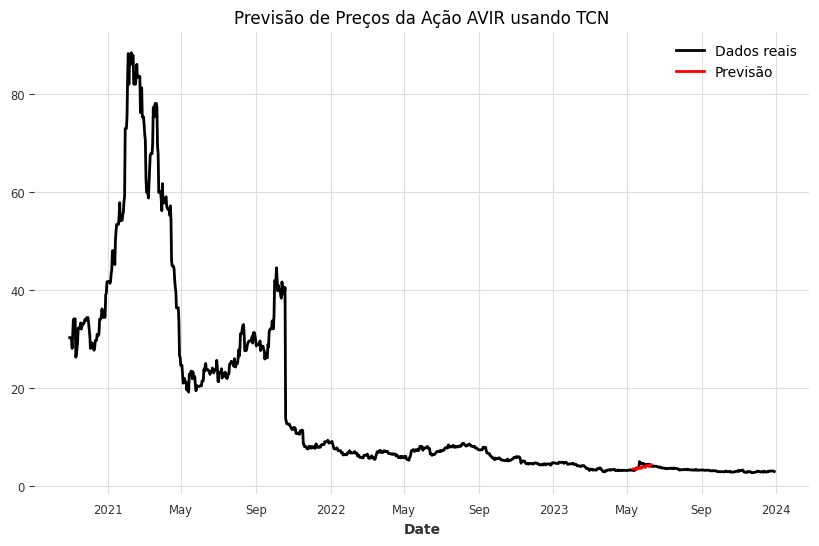

In [ ]:
import yfinance as yf
import torch
from darts import TimeSeries
from darts.models import TCNModel
import matplotlib.pyplot as plt
import pandas as pd  # Explicitly import pandas

# Baixar os dados da ação AVIR usando yfinance
data = yf.download("AVIR", start="2020-01-01", end="2024-01-01")

# Selecionar a coluna 'Close' para análise
# Ensure 'Date' is the index and convert to datetime
data = data.reset_index()  # Reset index if 'Date' is not already the index
data['Date'] = pd.to_datetime(data['Date'])  # Convert 'Date' to datetime
data = data.set_index('Date')  # Set 'Date' as the index

# Resample to daily frequency and fill missing values
data = data.resample('D').ffill()

# Create TimeSeries with explicit frequency
series = TimeSeries.from_dataframe(data, value_cols="Close", freq='D')  # Specify 'D' for daily frequency

# Dividir os dados em treinamento e teste (80% para treinamento, 20% para teste)
train, val = series.split_before(0.8)

# Definir e treinar o modelo TCN
model = TCNModel(
    input_chunk_length=30,  # Número de passos de entrada (janela de treinamento)
    output_chunk_length=7,  # Número de passos de saída (previsão para uma semana)
    kernel_size=3,
    num_filters=16,
    dilation_base=2,
    weight_norm=True,
    dropout=0.2,
    random_state=42,
)

# Treinando o modelo
model.fit(train)

# Fazer previsões no conjunto de validação
pred = model.predict(n=30, series=train)

# Plotar a série original e as previsões
plt.figure(figsize=(10, 6))
series.plot(label='Dados reais')
pred.plot(label='Previsão', color='red')
plt.legend()
plt.title("Previsão de Preços da Ação AVIR usando TCN")
plt.show()

Ainda não foi possível alinhar de forma assertiva.